In [73]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy import ndimage
from scipy import signal
from scipy.stats import linregress
from scipy.signal import convolve2d, gaussian, argrelextrema
from scipy.interpolate import interp1d
from sklearn.preprocessing import normalize
from skimage.transform import rotate
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle as cPickle
import librosa
import glob
import re
import sys
import os
import mido
from mido import MidiFile
import cv2
from PIL import Image

## Strip Analysis Functions

In [3]:
def locateStaffLines(s, delta = 3):
    medvals = np.median(s, axis=1)
    for i, curVal in enumerate(medvals):
        if i > delta and i < len(medvals)-delta:
            if curVal != np.max(medvals[i-delta:i+delta+1]): # only keep local maxima
                medvals[i] = 0
    idxs_sorted_val = np.argsort(medvals)[::-1]
    idxs_lines = sorted(idxs_sorted_val[0:10])
    return np.array(idxs_lines)

In [6]:
def estimateMidiNum2PixelRowMapping(s, lineIdxs, hand = 'right'):
    if hand == 'right':
        x = np.array([77, 74, 71, 67, 64]) # midi nums for staff lines
    elif hand == 'left':
        x = np.array([57, 53, 50, 47, 43])
    else:
        print('Unrecognized value for hand: %s' % hand)
        sys.exit(1)
    m, b, _, _, _ = linregress(x, lineIdxs)
    return (m,b)

In [7]:
def estimatePixelRow(midinum, m, b):
    return np.int(np.round(midinum * m + b))

### Get Strip of Sheet Music

In [30]:
test_image = Image.open(os.path.join("prepped_png_danielcopy", "bwv871_vfinale", "bwv871_vfinale-1.png")).convert('L')

In [33]:
img_array = np.array(test_image)
#img_array = img_array[:,:,::-1]
#plt.imshow(img_array)
img_array.shape

(792, 612)

In [34]:
print(img_array)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


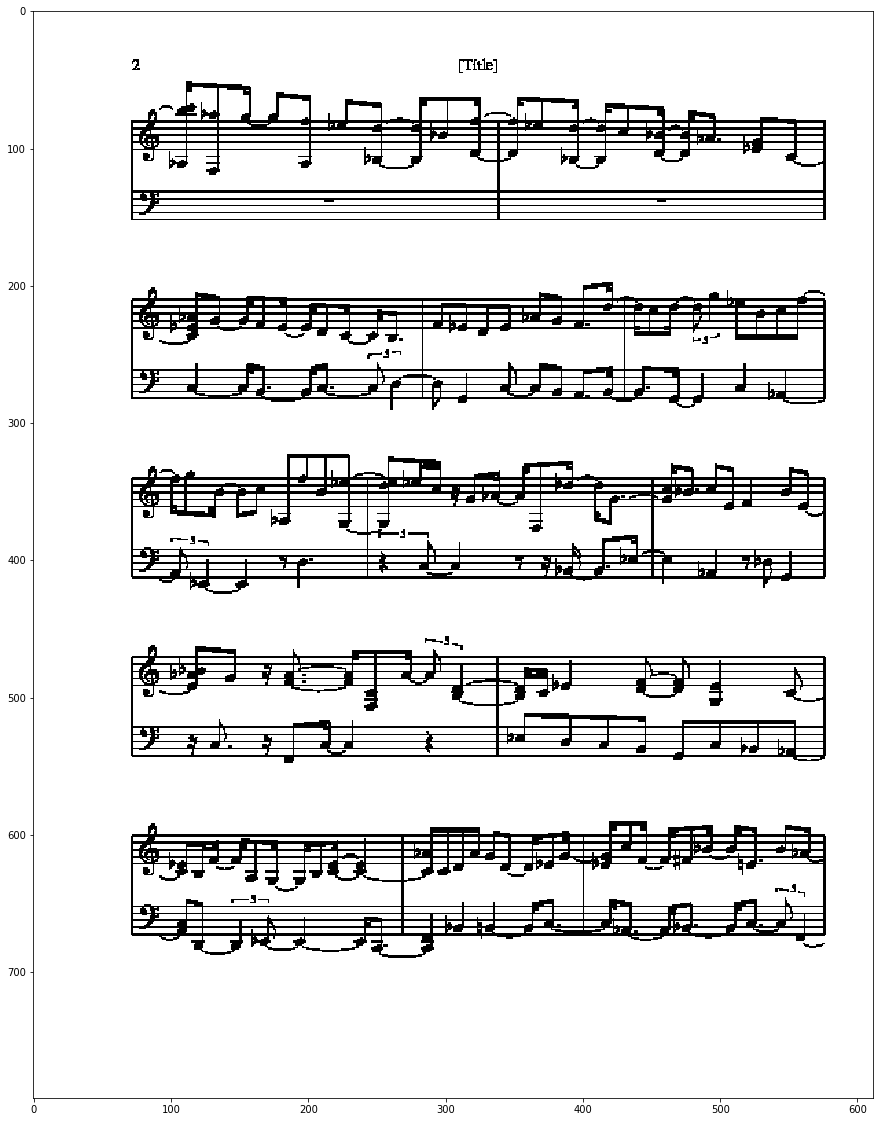

In [35]:
plt.figure(figsize=(20,20))
plt.imshow(img_array, cmap="gray")

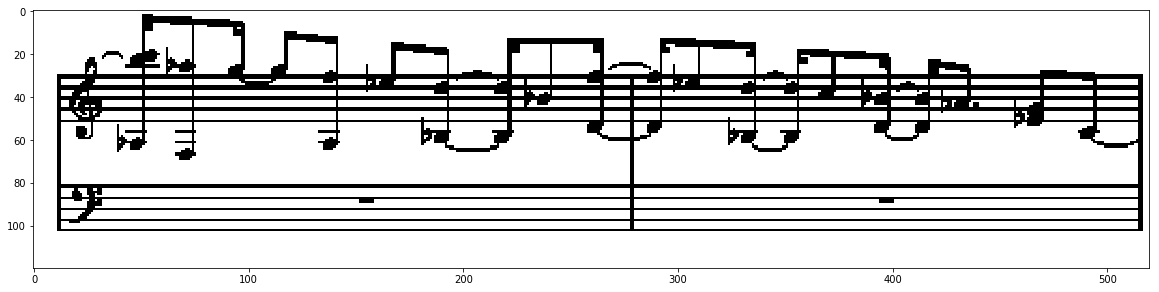

In [42]:
plt.figure(figsize=(20,20))
plt.imshow(img_array[50:170, 60:580], cmap="gray")

So here's one strip (we want both top and bottom)

In [43]:
strip = img_array[50:170, 60:580]

In [44]:
s = strip
lines = locateStaffLines(s)
breakpt = np.int(np.round(.5*(lines[4]+lines[5])))
m, b = estimateMidiNum2PixelRowMapping(s[0:breakpt,:], lines[0:5], 'right')
estC4 = estimatePixelRow(60, m, b)

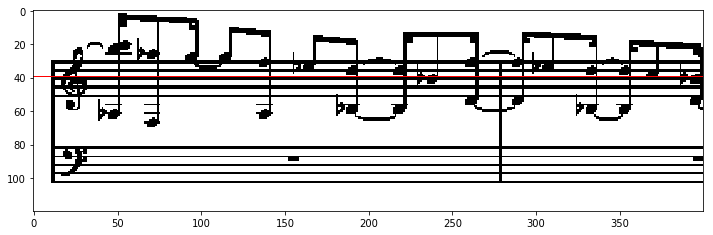

In [45]:
showImage(s[:,0:400])
plt.axhline(y = estC4, color='r', linewidth=1)
plt.show()

## Try some other things

In [52]:
sample_png = os.path.join("prepped_png_danielcopy", "bwv871_vfinale", "bwv871_vfinale-1.png")

### Import Image

In [62]:
def importImage(pngfile):
    img = ndimage.imread(pngfile, flatten=True)
    img = 1 - img/255.0 # make white -> 0, black -> 1
    return img

In [47]:
def showImage(X, sz = (12,12)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


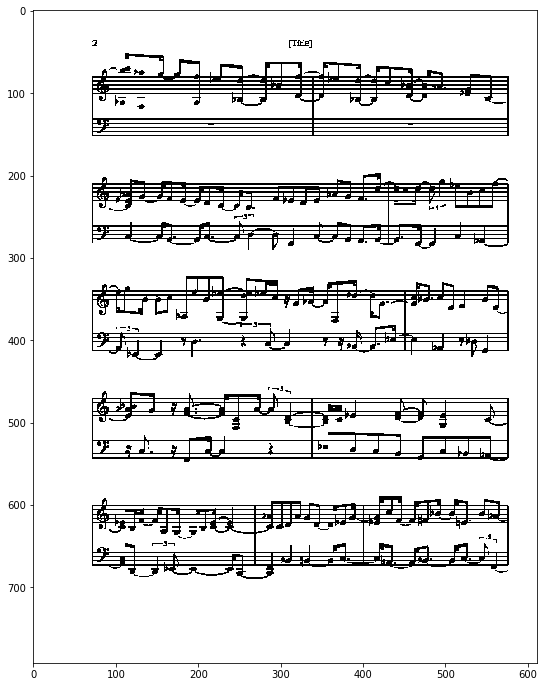

In [63]:
I = importImage(sample_png)
showImage(I)

#### Rotate to ensure horizontal lines

In [48]:
def rotateToHorizontal(img, lb=-.5, ub=.5, incr=.02, topN=40):
    bestscore = -np.inf
    bestTheta = 0
    for theta in np.arange(lb, ub, incr):
        imgRot = rotate(img,theta)
        rsums = np.sum(imgRot, axis=1)
        rsums_sorted = sorted(rsums)[::-1]
        curscore = np.sum(rsums_sorted[0:topN])
        if curscore > bestscore:
            bestscore = curscore
            bestTheta = theta
    result = rotate(img,bestTheta)
    return result, bestTheta

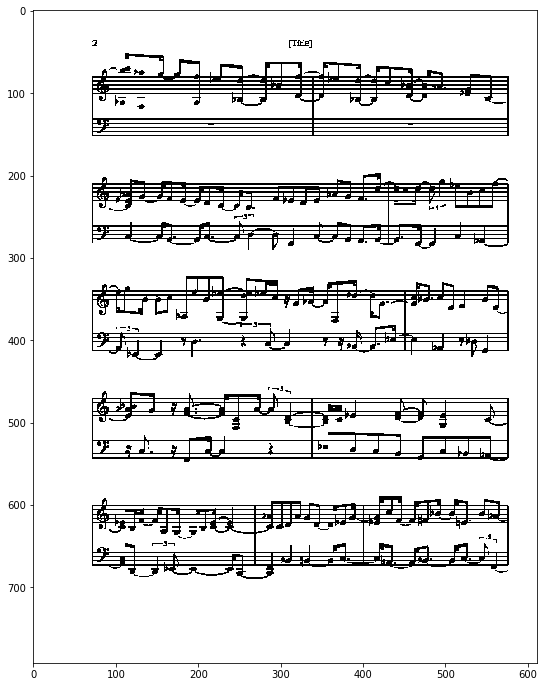

In [66]:
Irot, theta = rotateToHorizontal(I)
showImage(Irot)

#### Crop Whitespace

In [49]:
def getBoundingBox(img, thresh=.01, buff=0.05):
    r = img.shape[0]
    c = img.shape[1]
    
    cmeans = np.mean(img, axis=0)
    cmean_thresh = np.max(cmeans) * thresh
    cidxs_above = np.argwhere(cmeans > cmean_thresh)
    col_start = cidxs_above[0][0]
    col_end = cidxs_above[-1][0]
    
    rmeans = np.mean(img, axis=1)
    rmean_thresh = np.max(rmeans) * thresh
    ridxs_above = np.argwhere(rmeans > rmean_thresh)
    row_start = ridxs_above[0][0]
    row_end = ridxs_above[-1][0]
    
    # add buffer to ignore clefs
    bufflen = np.int((col_end - col_start) * buff)
    col_start_adj = col_start + bufflen
    
    return (row_start, col_start_adj), col_end - col_start_adj, row_end - row_start

In [50]:
def showImageWithBB(X, loc, w, h, sz=(12,12)):
    fig = plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')
    ax = fig.gca()
    rect = patches.Rectangle((loc[1],loc[0]), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [51]:
def  getCropped (X):
    ll, w, h = getBoundingBox(X)
    return X[ll[0]:ll[0]+h,ll[1]:ll[1]+w]

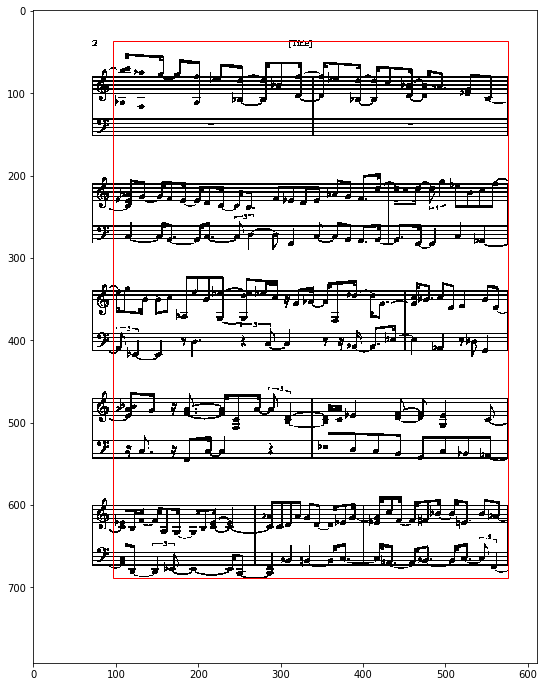

In [69]:
ll, bbw, bbh = getBoundingBox(Irot)
showImageWithBB(Irot, ll, bbw, bbh)

#### Get Strip Boundaries

In [70]:
def getStripBoundaries(X, showPlot = False):
    
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    rsum = np.sum(Xfilt, axis=1)
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1))
    #assert(len(peakidxs) % 2 == 0)
    
    # determine boundaries
    numStrips = np.int(len(peakidxs)/2) - 1 
    boundaries = []
    for i in range(numStrips):
        peak1idx = peakidxs[2*i + 1]
        peak2idx = peakidxs[2*i + 2]
        midpt = np.int((peak1idx + peak2idx)/2.0)
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

In [71]:
def visualizeBoundaries(X, bnds, savefile = None):
    showImage(X)
    for bnd in bnds:
        plt.axhline(y=bnd, color='r', linewidth=1)
    if savefile:
        plt.savefig(savefile)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


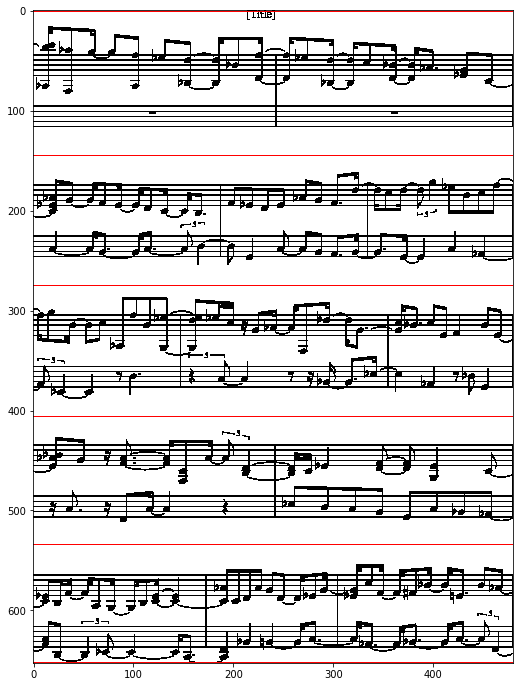

In [74]:
Icrop = getCropped(Irot)
bnds = getStripBoundaries(Icrop)
visualizeBoundaries(Icrop, bnds)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


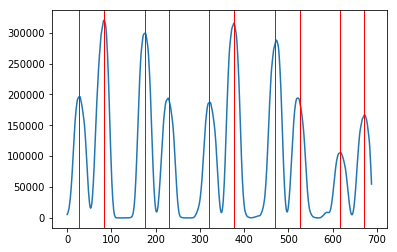

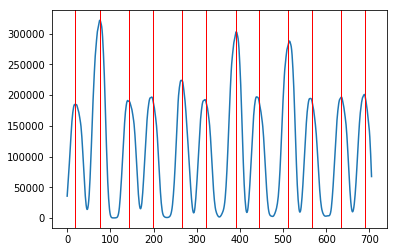

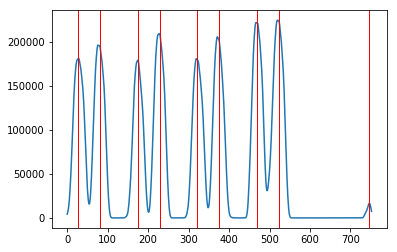

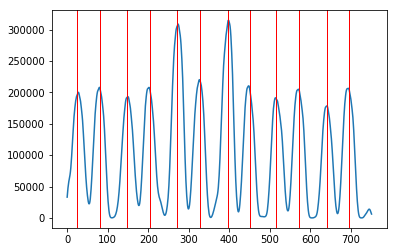

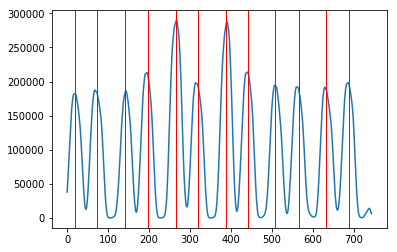

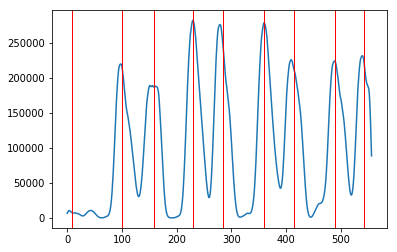

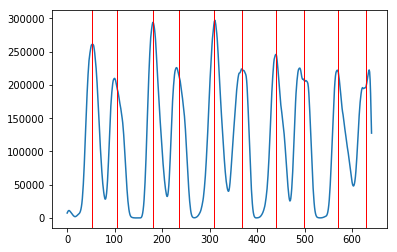

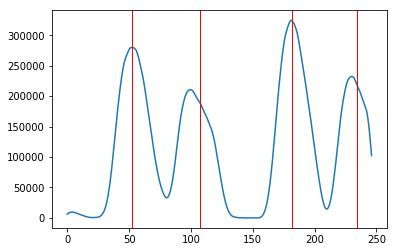

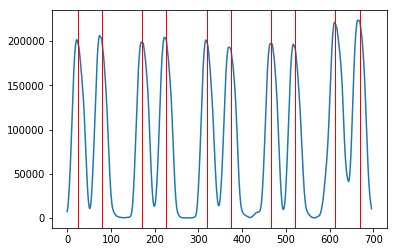

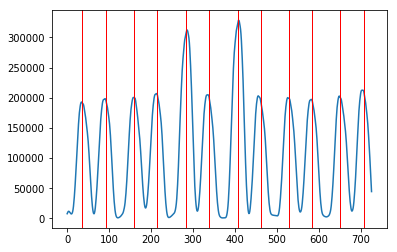

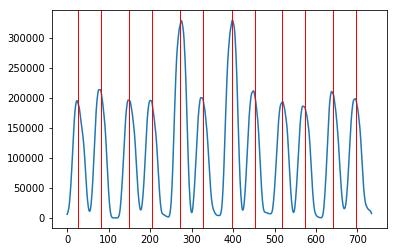

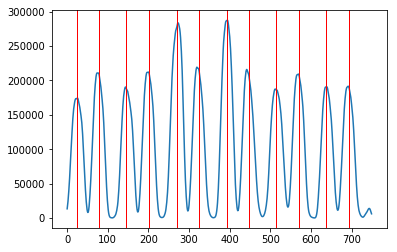

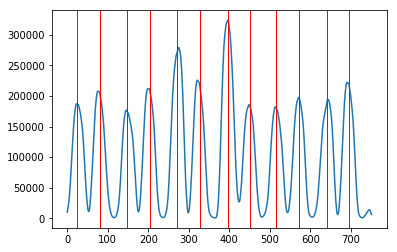

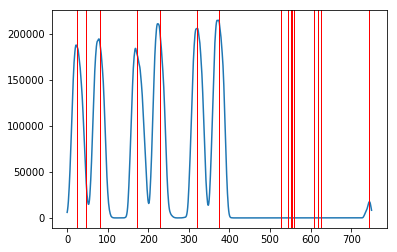

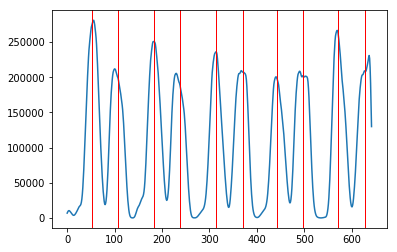

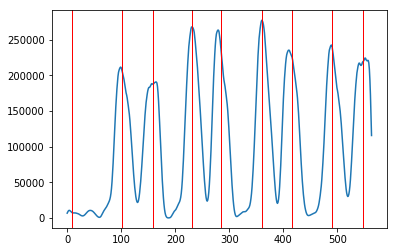

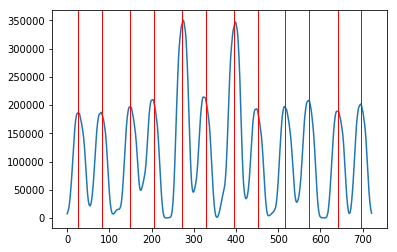

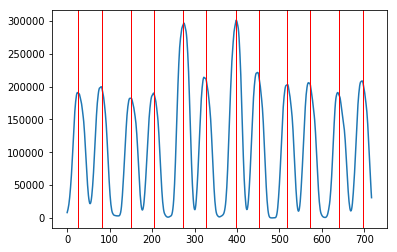

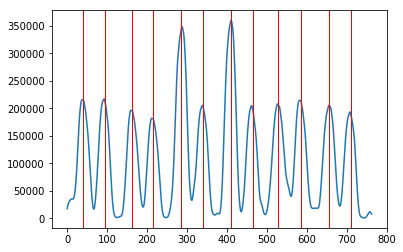

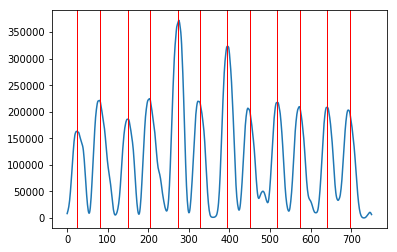

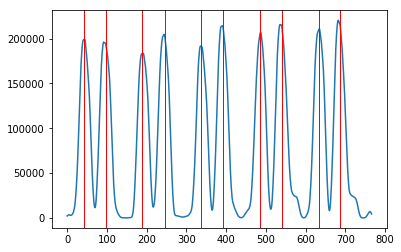

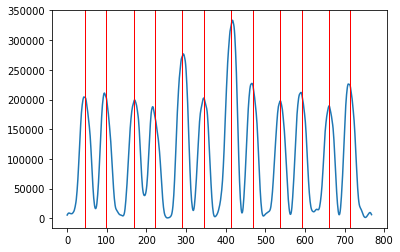

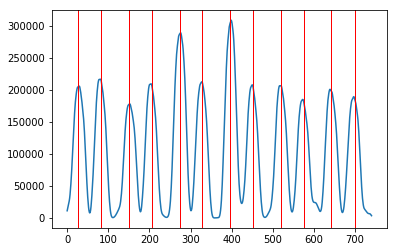

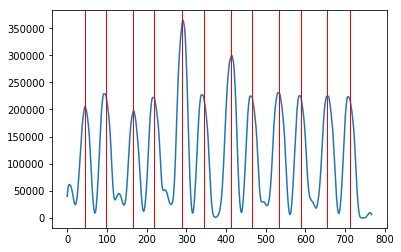

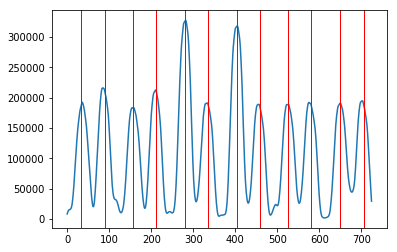

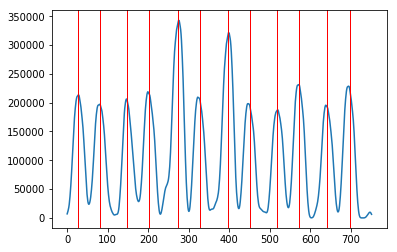

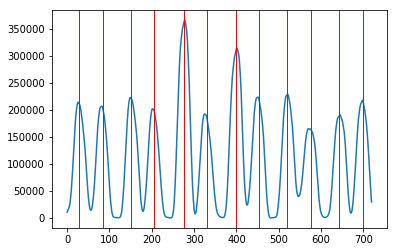

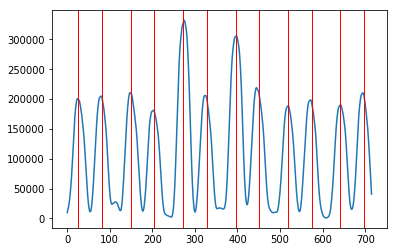

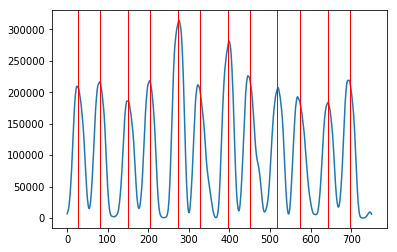

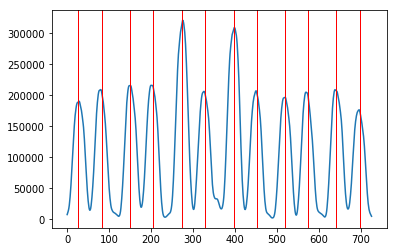

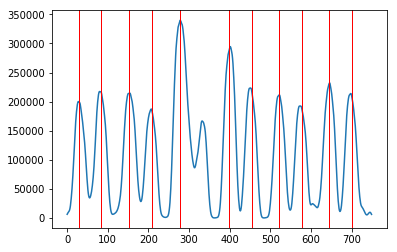

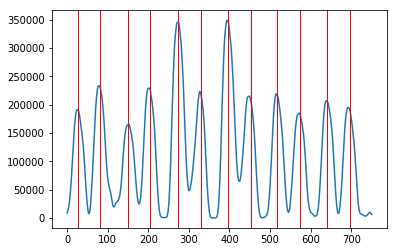

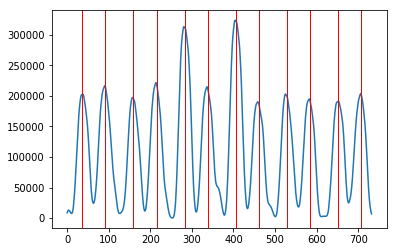

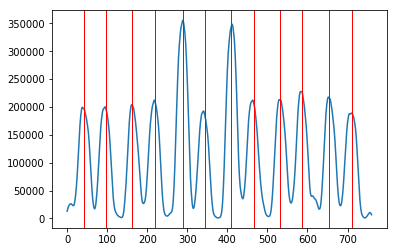

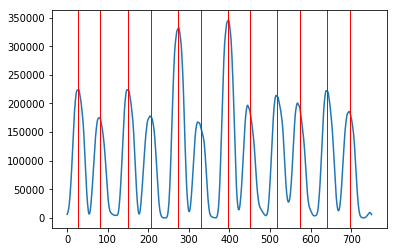

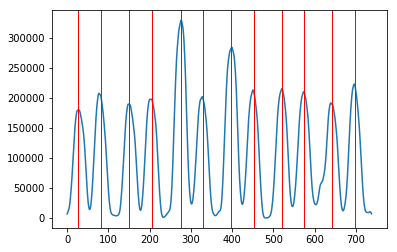

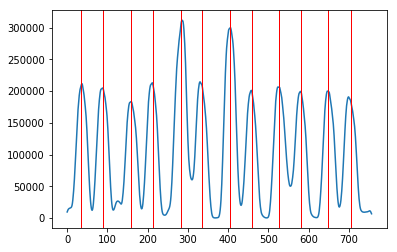

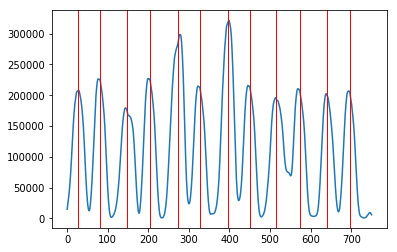

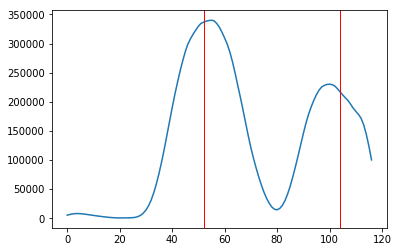

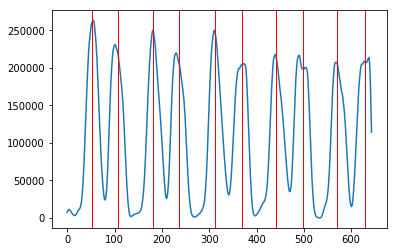

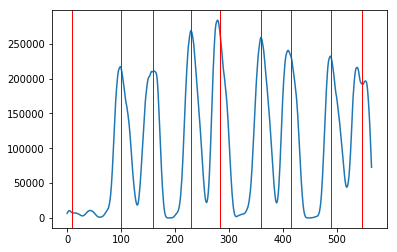

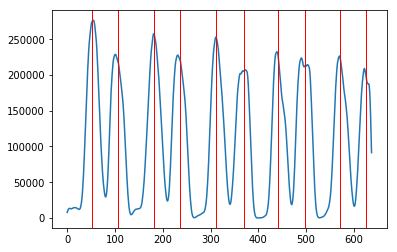

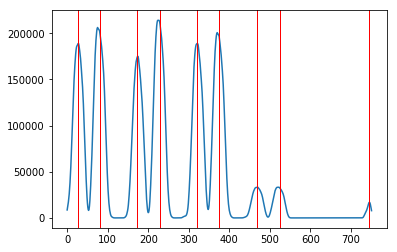

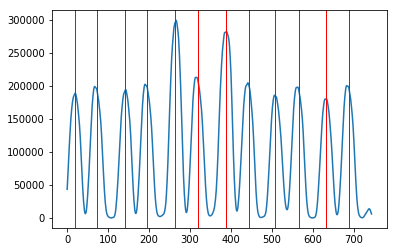

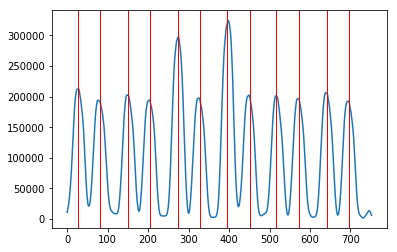

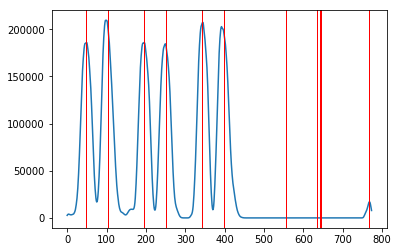

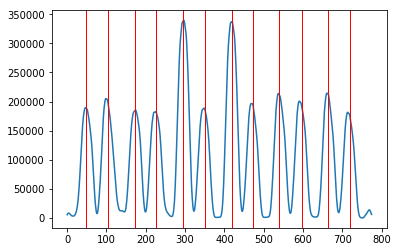

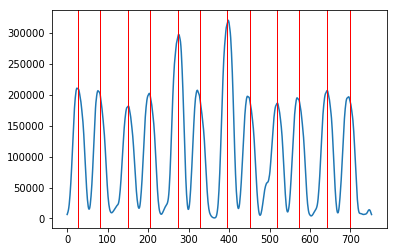

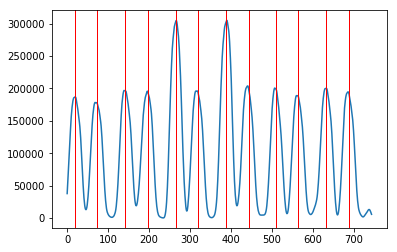

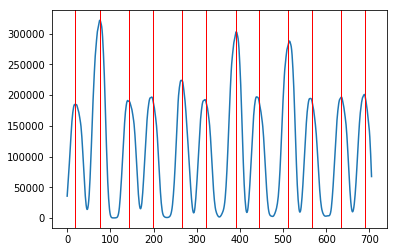

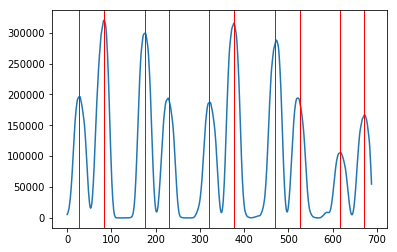

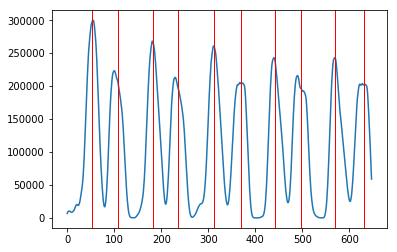

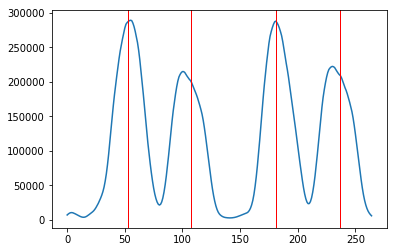

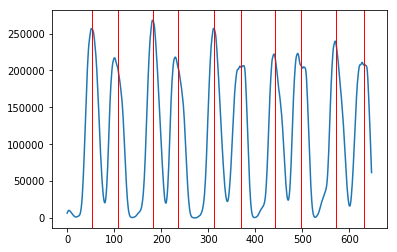

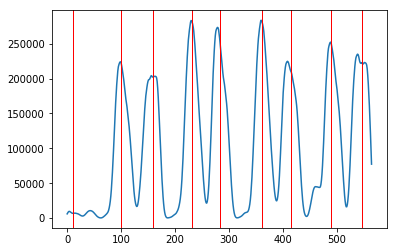

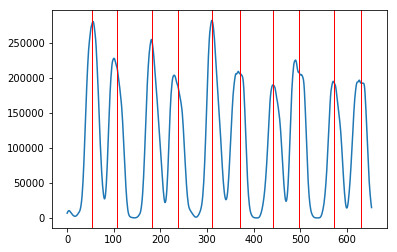

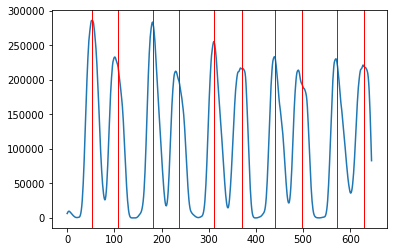

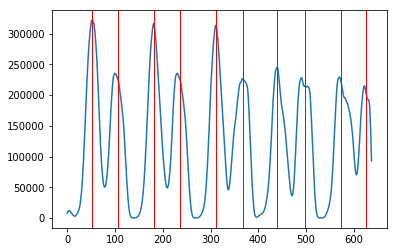

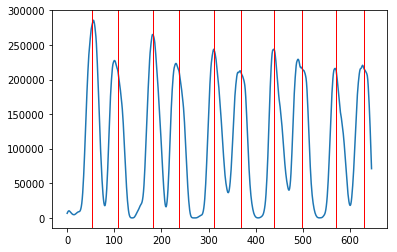

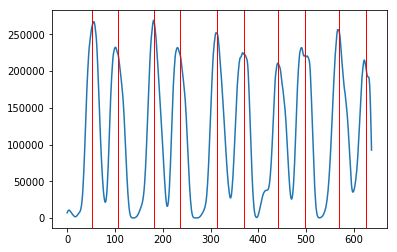

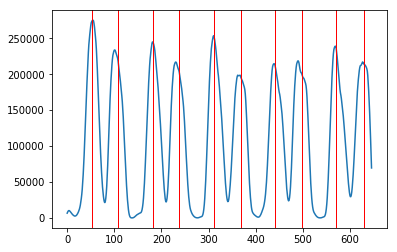

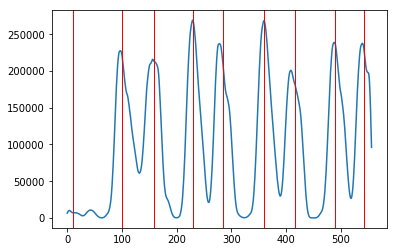

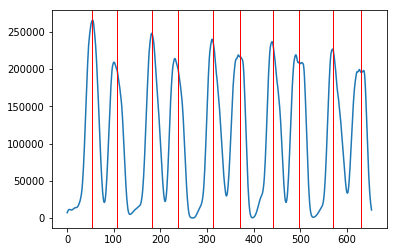

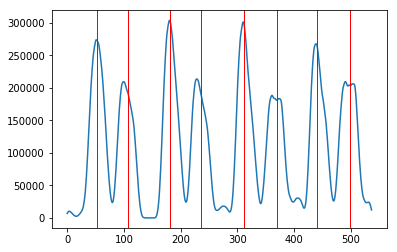

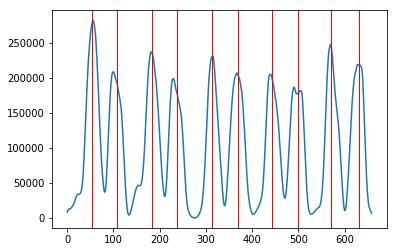

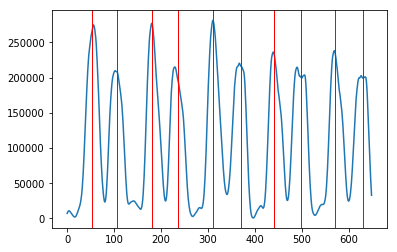

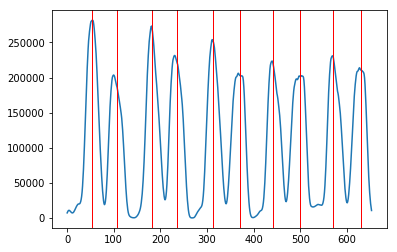

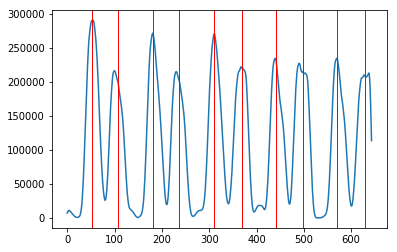

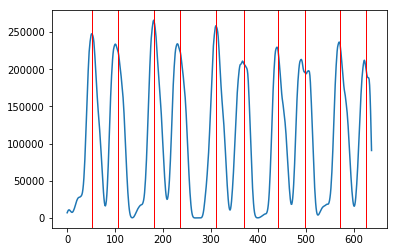

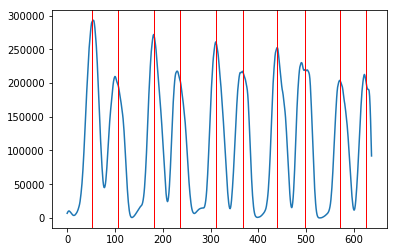

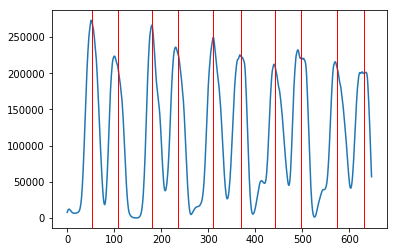

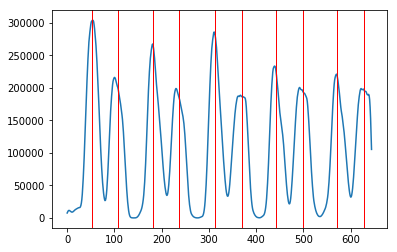

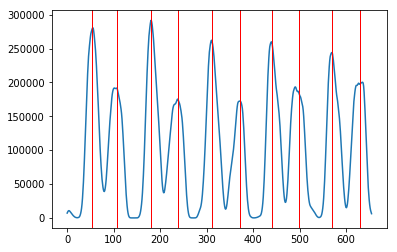

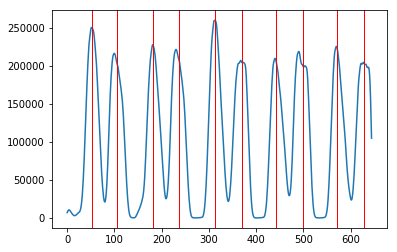

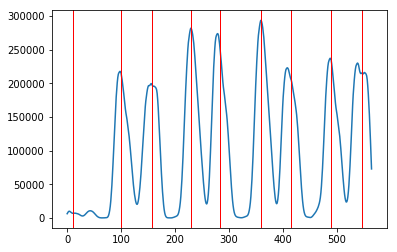

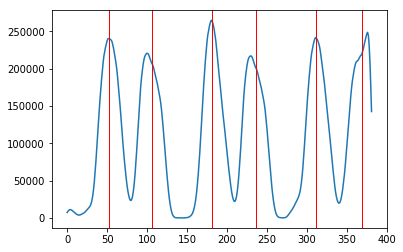

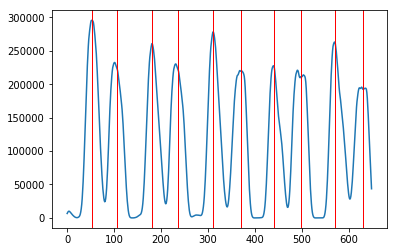

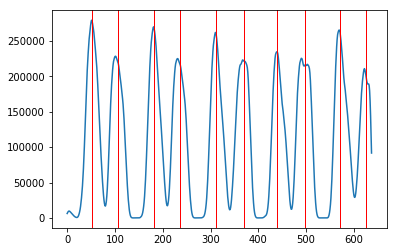

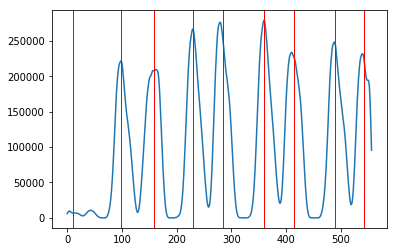

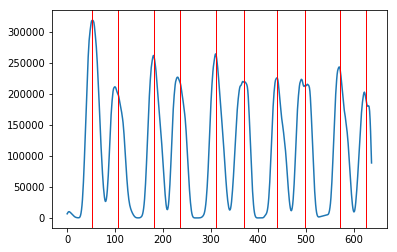

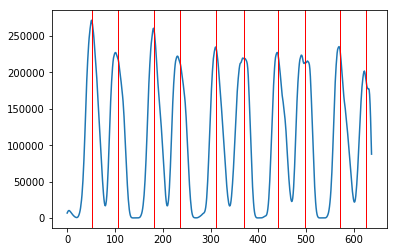

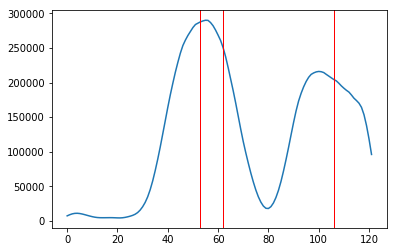

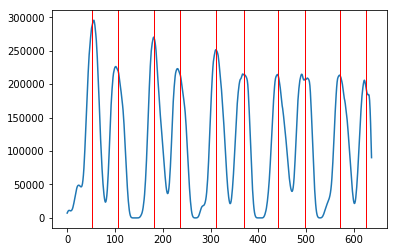

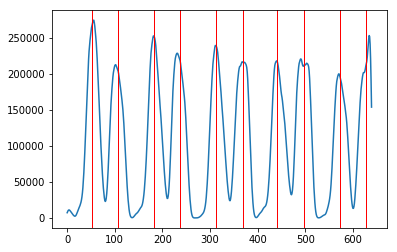

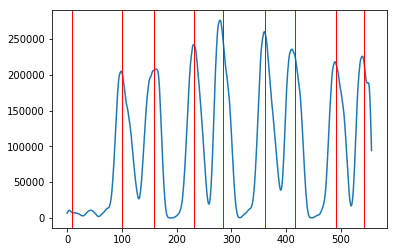

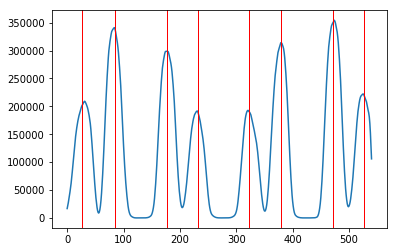

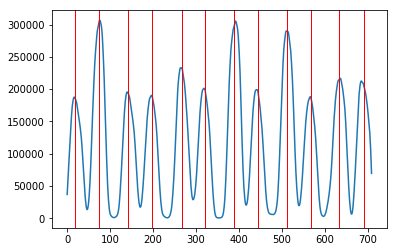

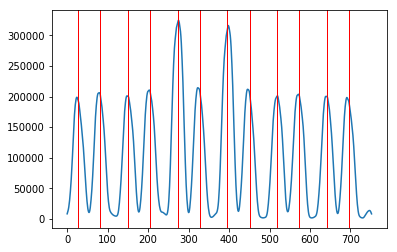

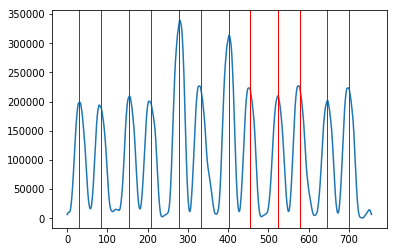

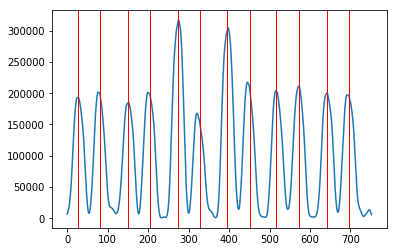

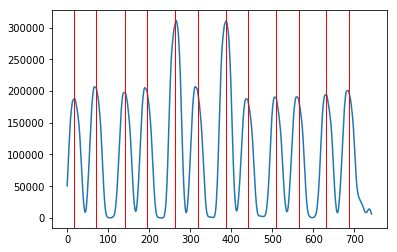

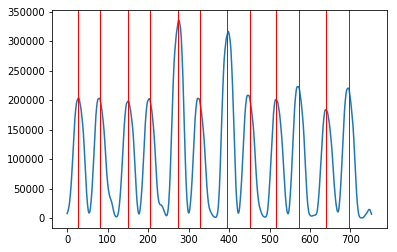

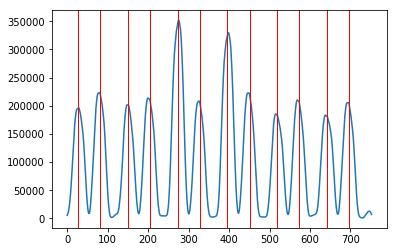

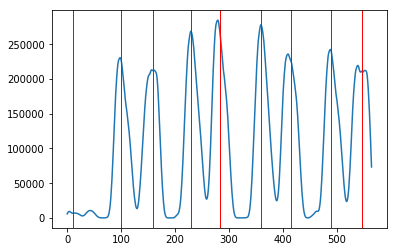

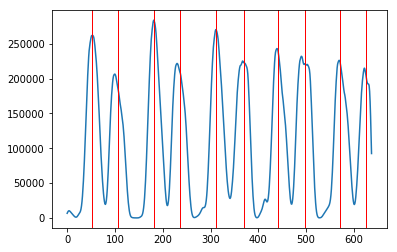

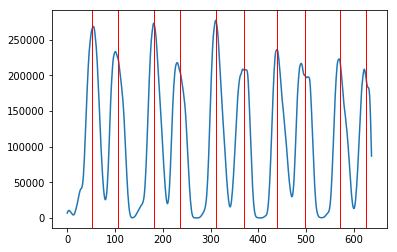

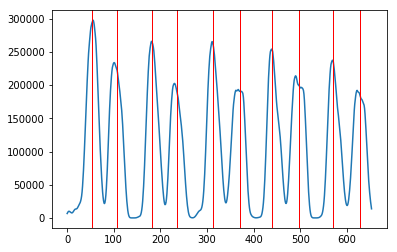

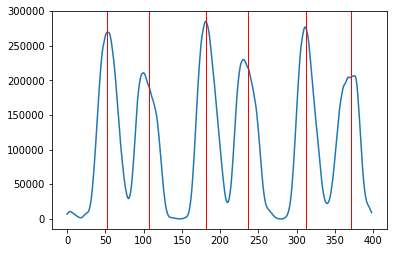

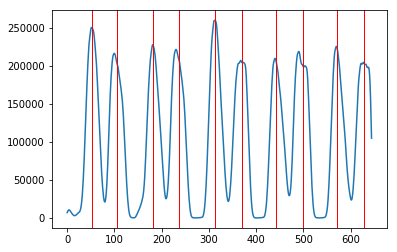

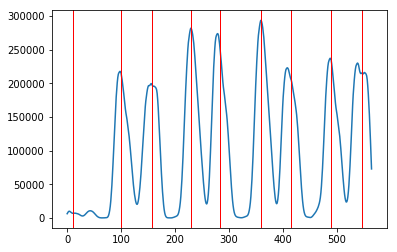

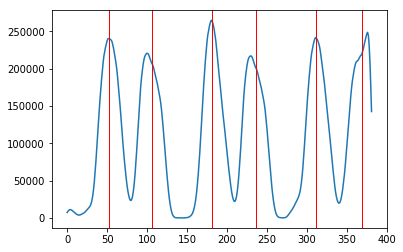

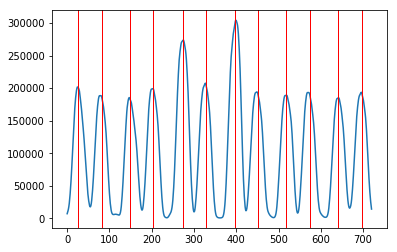

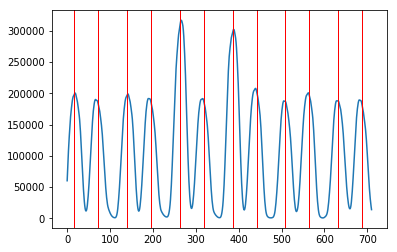

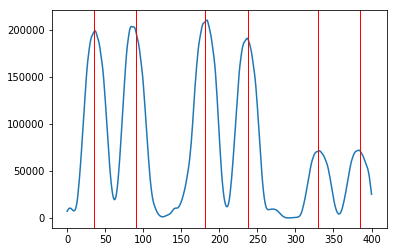

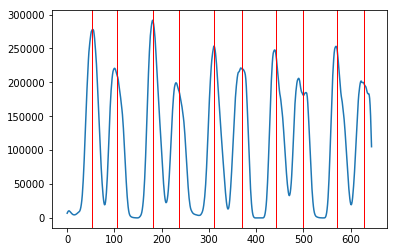

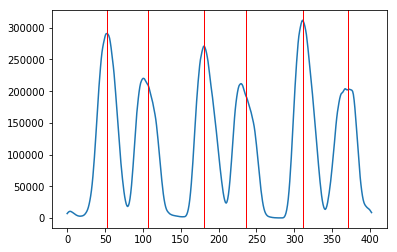

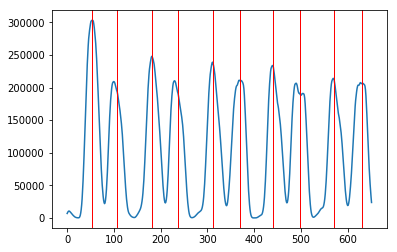

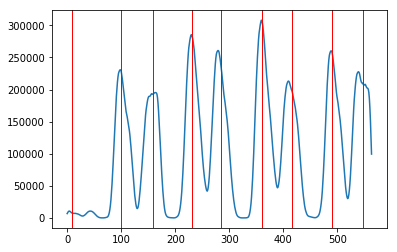

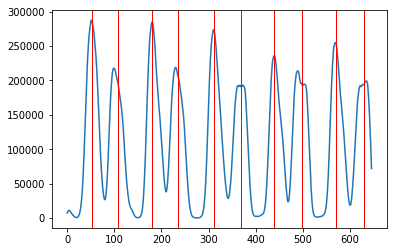

In [75]:
pngfiles = glob.glob('prepped_png_danielcopy/*/*.png')
for pngfile in pngfiles:
    I = importImage(pngfile)
    Irot, theta = rotateToHorizontal(I)
    ll, bbw, bbh = getBoundingBox(Irot)
    Icrop = getCropped(Irot)
    bnds = getStripBoundaries(Icrop, True)
    plt.show()

#### Pull Strips

In [76]:
def getStrips(X, bnds):
    strips = []
    for i in range(len(bnds)-1):
        rstart = bnds[i]
        rend = bnds[i+1] + 1 # include endpoint
        chunk = X[rstart:rend,:]
        strips.append(chunk)
    return strips

In [77]:
def showStrips(strips):
    for strip in strips:
        showImage(strip)

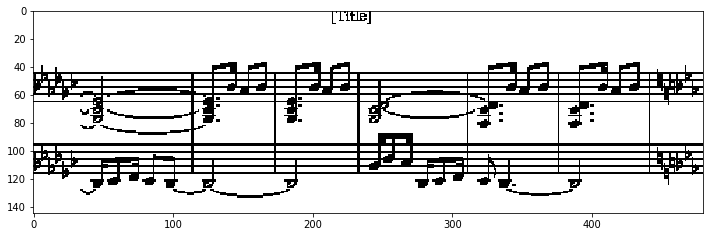

In [78]:
strips = getStrips(Icrop, bnds)
showImage(strips[0])

### Verify Strips Reasonable

#### Visualize

In [79]:
def inspectBoundariesPre(filelist, outdir):
    os.mkdir(outdir)
    predfile = outdir + '/bnds.predicted.txt' # text file with boundary predictions
    f = open(predfile,'w')
    for i, curfile in enumerate(filelist):
        
        # get strip boundaries
        I = importImage(curfile)
        Irot, theta = rotateToHorizontal(I)
        ll, w, h = getBoundingBox(Irot)
        Icrop = getCropped(Irot)
        bnds = getStripBoundaries(Icrop)
        
        # generate images for inspection
        basename = os.path.splitext(os.path.basename(curfile))[0]
        outfile = '%s/%s.png' % (outdir,basename)
        visualizeBoundaries(Icrop, bnds, outfile)
        
        # write to text file
        strOut = '%s %s\n' % (basename, ' '.join(map(str,bnds)))
        f.write(strOut)
        
    f.close()

In [80]:
png_dir = 'prepped_png_danielcopy'

In [ ]:
png_filespng_file  = sorted(glob.glob(png_dir + '/*/*.png'))
visualize_dir_pre = 'visualize_boundaries_init'